In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
import numpy as np
%matplotlib inline

In [2]:
IBMQ.load_account()

C:\Users\josev\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
shots = 2**14
A = 1.47e-6 #unit of A is eV
hbar = 4.1357e-15 #Planck's constant in eV
c = 3e10 #cgs units
E_sim = []

qubits = QuantumRegister(2, name='qubits')
bits = ClassicalRegister(2, name='bits')

In [4]:
backend = Aer.get_backend('qasm_simulator')

In [5]:
measure_ZZ = QuantumCircuit(qubits,bits)
measure_ZZ.measure(qubits,bits)

measure_XX = QuantumCircuit(qubits,bits)
measure_XX.h(qubits)
measure_XX.measure(qubits,bits)

measure_YY = QuantumCircuit(qubits,bits)
measure_YY.p(-np.pi/2,qubits)
measure_YY.h(qubits)
measure_YY.measure(qubits,bits)

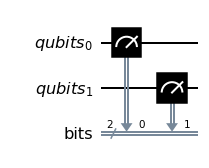

In [6]:
measure_ZZ.draw('mpl')

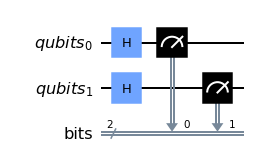

In [7]:
measure_XX.draw('mpl')

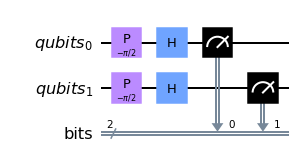

In [8]:
measure_YY.draw('mpl')

In [9]:
Triplet1 = QuantumCircuit(qubits)
Triplet1.h(qubits[0])
Triplet1.cx(qubits[0],qubits[1])

Triplet2 = QuantumCircuit(qubits)
Triplet2.x(qubits[0])
Triplet2.h(qubits[0])
Triplet2.cx(qubits[0],qubits[1])

Triplet3 = QuantumCircuit(qubits)
Triplet3.h(qubits[0])
Triplet3.x(qubits[1])
Triplet3.cx(qubits[0],qubits[1])

Singlet = QuantumCircuit(qubits)
Singlet.x(qubits)
Singlet.h(qubits[0])
Singlet.cx(qubits[0],qubits[1])

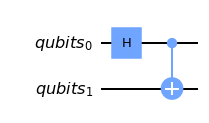

In [10]:
Triplet1.draw('mpl')

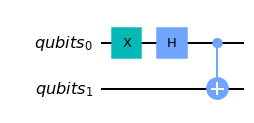

In [11]:
Triplet2.draw('mpl')

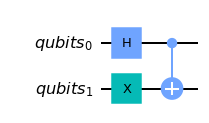

In [12]:
Triplet3.draw('mpl')

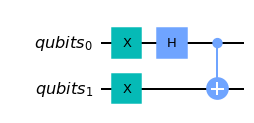

In [13]:
Singlet.draw('mpl')

In [14]:
def Calculate_Energy(Triplet1,Triplet2,Triplet3,Singlet,measure_XX,measure_YY,measure_ZZ,backend,shots,A,E_sim):
    for state_init in [Triplet1,Triplet2,Triplet3,Singlet]:
        Energy_meas = []
        for measure_circuit in [measure_XX,measure_YY,measure_ZZ]:
            qc = state_init+measure_circuit
            counts = execute(qc,backend=backend,shots=shots).result().get_counts()
            probs = {}
            for output in ['00','01','10','11']:
                if output in counts:
                    probs[output] = counts[output]/shots
                else:
                    probs[output] = 0
            Energy_meas.append(probs['00']-probs['01']-probs['10']+probs['11'])
            
        E_sim.append(A*np.sum(np.array(Energy_meas)))    

In [15]:
Calculate_Energy(Triplet1,Triplet2,Triplet3,Singlet,measure_XX,measure_YY,measure_ZZ,backend,shots,A,E_sim)

In [16]:
print('Energy expection value of the state Triplet1 : {:.3e} eV'.format(E_sim[0]))
print('Energy expection value of the state Triplet2 : {:.3e} eV'.format(E_sim[1]))
print('Energy expection value of the state Triplet3 : {:.3e} eV'.format(E_sim[2]))
print('Energy expection value of the state Singlet : {:.3e} eV'.format(E_sim[3]))

Energy expection value of the state Triplet1 : 1.470e-06 eV
Energy expection value of the state Triplet2 : 1.470e-06 eV
Energy expection value of the state Triplet3 : 1.470e-06 eV
Energy expection value of the state Singlet : -4.410e-06 eV


In [17]:
E_del = abs(E_sim[0]-E_sim[3])

f = E_del/hbar

wavelength = c/f

print('The wavelength of the radiation from the transition\
 in the hyperfine structure is : {:.1f} cm'.format(wavelength))

The wavelength of the radiation from the transition in the hyperfine structure is : 21.1 cm


In [18]:
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_santiago')

In [19]:
qc_all = [state_init+measure_circuit for state_init in [Triplet1,Triplet2,Triplet3,Singlet] 
          for measure_circuit in [measure_XX, measure_YY, measure_ZZ] ]  

shots = 8192
job = execute(qc_all,initial_layout=[3,4], backend=qcomp, optimization_level=3, shots=shots)
print(job.job_id())
job_monitor(job)

607279cdbb1d8817c508d0e6
Job Status: job has successfully run


In [20]:
#results = qcomp.retrieve_job('6045c84f1708848283289090').result()
results = job.result()

In [21]:
def Energy(results, shots):
    """Compute the energy levels of the hydrogen ground state.
    
    Parameters:
        results (obj): results, results from executing the circuits for measuring a hamiltonian.
        shots (int): shots, number of shots used for the circuit execution.
        
    Returns:
        Energy (list): energy values of the four different hydrogen ground states
    """
    E = []
    A = 1.47e-6

    for ind_state in range(4):
        Energy_meas = []
        for ind_comp in range(3):
            counts = results.get_counts(ind_state*3+ind_comp)
        
            # calculate the probabilities for each computational basis
            probs = {}
            for output in ['00','01', '10', '11']:
                if output in counts:
                    probs[output] = counts[output]/shots
                else:
                    probs[output] = 0
            
            Energy_meas.append( probs['00'] - probs['01'] - probs['10'] + probs['11'] )

        E.append(A * np.sum(np.array(Energy_meas)))
    
    return E

In [22]:
E = Energy(results, shots)

print('Energy expection value of the state Triplet1 : {:.3e} eV'.format(E[0]))
print('Energy expection value of the state Triplet2 : {:.3e} eV'.format(E[1]))
print('Energy expection value of the state Triplet3 : {:.3e} eV'.format(E[2]))
print('Energy expection value of the state Singlet : {:.3e} eV'.format(E[3]))

Energy expection value of the state Triplet1 : 1.419e-06 eV
Energy expection value of the state Triplet2 : 1.376e-06 eV
Energy expection value of the state Triplet3 : 1.382e-06 eV
Energy expection value of the state Singlet : -4.186e-06 eV


In [23]:
cal_circuits, state_labels = complete_meas_cal(qr = 2, circlabel = 'measerrormitigationcal')

cal_job = execute(cal_circuits, backend = qcomp, shots = 8192, optimization_level = 3)
print(cal_job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(cal_job)
cal_results = cal_job.result()

60728075826b0d7e5bcdf2a9
Job Status: job has successfully run


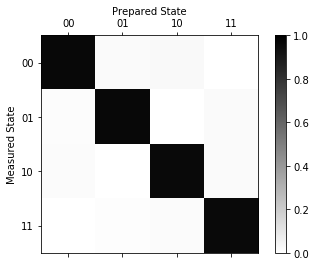

In [24]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter
meas_fitter.plot_calibration()

In [25]:
results_new = meas_filter.apply(results)

In [26]:
E_new = Energy(results_new, shots)

print('Energy expection value of the state Tri1 : {:.3e} eV'.format(E_new[0]))
print('Energy expection value of the state Tri2 : {:.3e} eV'.format(E_new[1]))
print('Energy expection value of the state Tri3 : {:.3e} eV'.format(E_new[2]))
print('Energy expection value of the state Sing : {:.3e} eV'.format(E_new[3]))

Energy expection value of the state Tri1 : 1.470e-06 eV
Energy expection value of the state Tri2 : 1.470e-06 eV
Energy expection value of the state Tri3 : 1.470e-06 eV
Energy expection value of the state Sing : -4.408e-06 eV


In [27]:
# results for the energy estimation from the simulation, 
# execution on a quantum system without error mitigation and
# with error mitigation in numpy array format 
Energy_exact, Energy_exp_orig, Energy_exp_new = np.array(E_sim), np.array(E), np.array(E_new)

In [28]:
# Calculate the relative errors of the energy values without error mitigation 
# and assign to the numpy array variable `Err_rel_orig` of size 4
Err_rel_orig = ((Energy_exact-Energy_exp_orig)/Energy_exact)*100

In [29]:
# Calculate the relative errors of the energy values with error mitigation 
# and assign to the numpy array variable `Err_rel_new` of size 4
Err_rel_new = ((Energy_exact-Energy_exp_new)/Energy_exact)*100

In [30]:
np.set_printoptions(precision=3)

print('The relative errors of the energy values for four bell basis\
 without measurement error mitigation : {}'.format(Err_rel_orig))

The relative errors of the energy values for four bell basis without measurement error mitigation : [3.442 6.396 5.981 5.086]


In [31]:
np.set_printoptions(precision=3)

print('The relative errors of the energy values for four bell basis\
 with measurement error mitigation : {}'.format(Err_rel_new))

The relative errors of the energy values for four bell basis with measurement error mitigation : [-2.396e-11 -2.991e-11 -2.936e-11  4.100e-02]
